Mid term Report title


In [84]:
# Import libraries and modules
import yfinance as yf
import snscrape.modules.twitter as sntwitter
import pandas as pd
import json
import os


import matplotlib.pyplot as plt

# Show all matplotlib graphs inline
%matplotlib inline


In [11]:
#Scope Limits
StartTime = "2012-05-01"
EndTime = "2022-05-01"
TweetLimit = 100


# caching folders
TweetCacheFolder = "CachedTweets"
StockCacheFolder = "CachedStockData"

Collect Twitter Data

In [12]:
#what users do we care about

# names from
# https://en.wikipedia.org/wiki/List_of_most-followed_Twitter_accounts

with open("TwitterUserNames.json", "r") as file:
	usernames = json.load(file)

In [13]:
#get tweets from users
def GetTweetsFromUser(username):

	if not os.path.isdir(TweetCacheFolder):
		os.mkdir(TweetCacheFolder)

	cachePath = os.path.join(TweetCacheFolder, "tweets_" + username + ".csv")

	# cache exists
	if os.path.exists(cachePath):
		df = pd.read_csv(cachePath)

	else:
		query = "(from:" + username + ") since:" + StartTime + " until:" + EndTime
		
		tweets = []
		for tweet in sntwitter.TwitterSearchScraper(query).get_items():

			if len(tweets) == TweetLimit:
				break
			else:
				# print(tweet.json())
				#break
				tweets.append([tweet.date, tweet.user.username, tweet.content, tweet.replyCount, tweet.retweetCount, tweet.likeCount, tweet.quoteCount, tweet.id])
		
		df = pd.DataFrame(tweets, columns=['Date', 'User', 'Content', 'ReplyCount', 'RetweetCount', 'LikeCount', 'QuoteCount', 'TweetID'])

		# to save to csv as a cache
		df.to_csv(cachePath)
	

	return df

tweetsDf = GetTweetsFromUser(usernames[0])

In [14]:
for username in usernames:
	tweetsDf = GetTweetsFromUser(username)


Collect Stock Market Data

In [27]:
#load stocks to track
with open("StockTags_SnP.json", "r") as file:
	stockTags = json.load(file)

stockTags = "TSLA"

In [28]:
def LoadStockData(stockTag):

	if not os.path.isdir(StockCacheFolder):
		os.mkdir(StockCacheFolder)

	cachePath = os.path.join(StockCacheFolder, "Stock_" + stockTag + ".csv")

	# cache exists
	if os.path.exists(cachePath):
		df = pd.read_csv(cachePath)

	if not os.path.exists(cachePath):
		stockDataDf = yf.download(stockTag, start=StartTime, end=EndTime, progress=False)

		#save data to local cache file
		stockDataDf.to_csv(cachePath)
	else:

		stockDataDf = pd.read_csv(cachePath)

	return stockDataDf

In [29]:

for stockTag in stockTags:
	LoadStockData(stockTag)


Now time to review the data downloaded

In [66]:
stockData = LoadStockData(stockTags[0])
stockData.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-04-30,24.569487,24.886707,24.561934,24.856495,11.689610,35286454
1,2012-05-01,24.871601,25.173716,24.871601,24.969790,11.742894,37497534
2,2012-05-02,24.954683,25.052870,24.811178,24.954683,11.735789,36978393
3,2012-05-03,24.788521,25.037764,24.743202,25.007553,11.760649,32713657
4,2012-05-04,24.954683,25.007553,24.788521,24.818731,11.671852,25303361


In [67]:
def CreateMovingAverage(df, columnToAverage, averageLength):

	movingAverage = []

	rows = df.loc[:,columnToAverage]
	for i in range(len(rows)):

		window = rows[i : i + averageLength]

		windowAverage = round(sum(window) / averageLength, 2)
		
		movingAverage.append(windowAverage)

	df.insert(len(df.columns), columnToAverage + "MA_" + str(averageLength), movingAverage)
	return

In [74]:
CreateMovingAverage(stockData, "Volume", 7)
CreateMovingAverage(stockData, "Volume", 30)
stockData.head()

,Date,Open,High,Low,Close,Adj Close,Volume,VolumeMA_7,VolumeMA_30
0,2012-04-30,24.569487,24.886707,24.561934,24.856495,11.689610,35286454,33885529.29,36370491.83
1,2012-05-01,24.871601,25.173716,24.871601,24.969790,11.742894,37497534,32929185.14,36421752.70
2,2012-05-02,24.954683,25.052870,24.811178,24.954683,11.735789,36978393,32090847.14,36343398.37
3,2012-05-03,24.788521,25.037764,24.743202,25.007553,11.760649,32713657,34749382.43,36505937.03
4,2012-05-04,24.954683,25.007553,24.788521,24.818731,11.671852,25303361,35751499.14,37250801.77


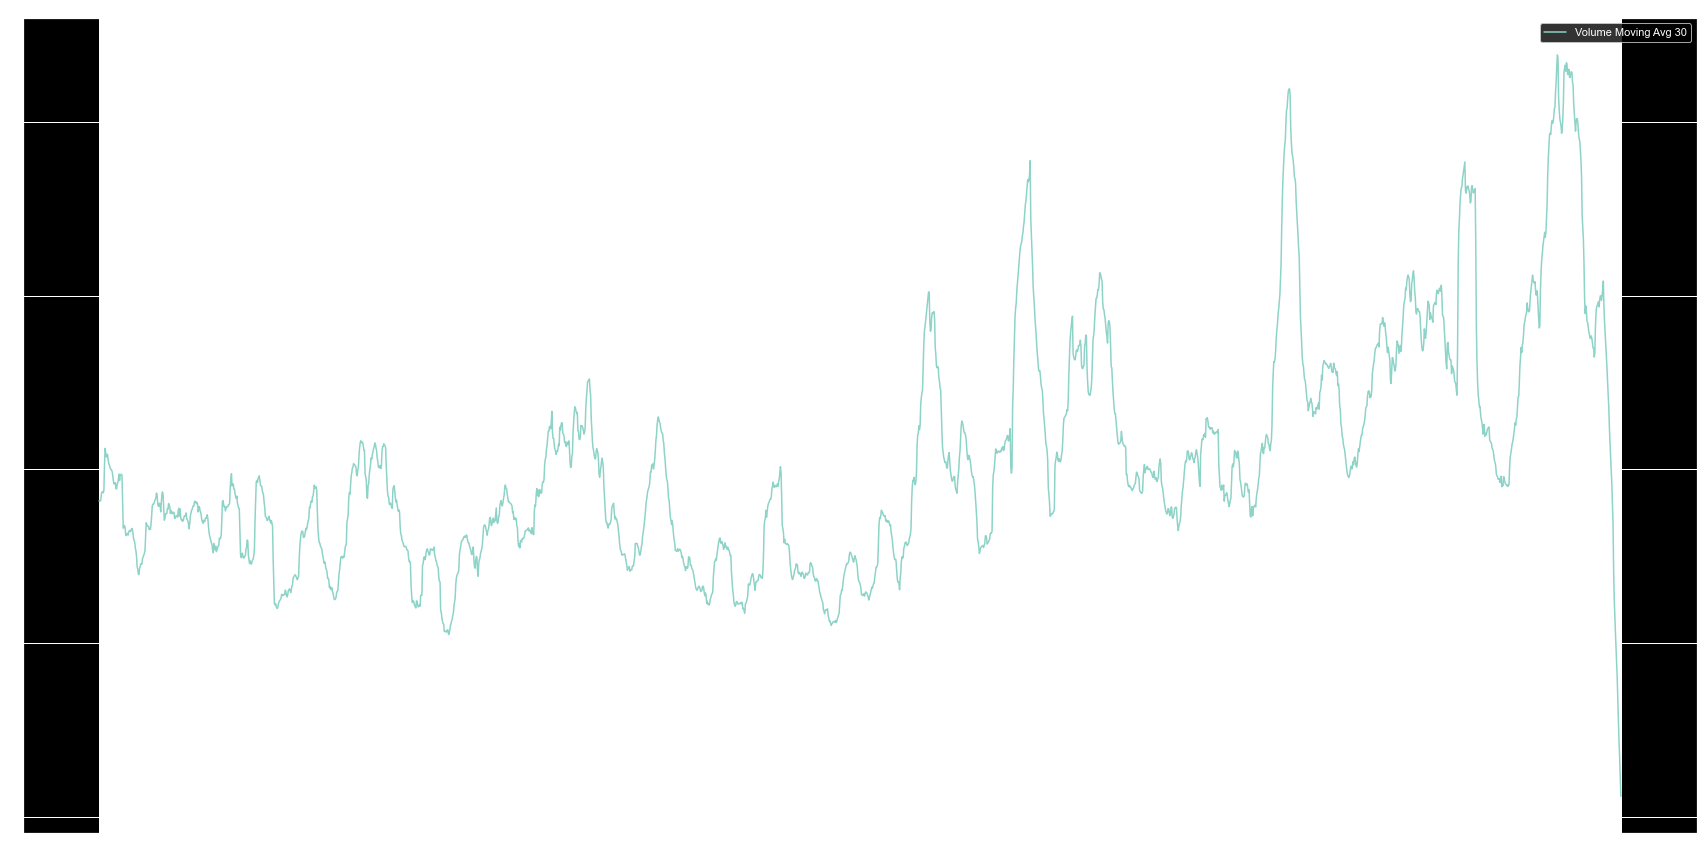

In [85]:
plt.rcParams['figure.figsize'] = [30, 15]

# plt.plot(stockData["Date"], stockData["Volume"], label = "Volume")
# plt.plot(stockData["Date"], stockData["VolumeMA_7"], label = "Volume Moving Avg 7")
plt.plot(stockData["Date"], stockData["VolumeMA_30"], label = "Volume Moving Avg 30")
plt.legend()
plt.show()